# Assignment 5: Randomization test 2
## Learning Outcomes
We will continue our last homework on the use of randomization and Monte-Carlo simulation tests to determine whether a specific effect is statistically significant. Randomization and simulation tests are universal and powerful way to do this, and form an essential part of the toolkit of any Data Scientist. 
## Problem Description
In Task 1 & 2, we continue with the movie dataset. The first two task build on the last homework and run randomization tests with two new test statistics. You should re-use the randomization test function that you wrote for the last homework – but the new modified version needs to be included in the submission. In Task 3 you are asked to program a simple monte-Carlo simulation test.  
## Preliminaries
Set up the environment by importing pandas, numpy, and matplotlib. Load the movie data set into a pandas data frame. **IMPORTANT: Download and used the new movie data set that comes with this assignment on OWL**. For older versions, you my need to configure your notebook such that plots are shown inline (see Assignment 2). 

In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.stats as stats

# Maybe necessary: 
matplotlib.use('TkAgg')
%matplotlib inline

df = pd.read_csv('movieDataset.csv')

## TASK 1: Chi-square test of independence (40pts)
To test whether two discrete variables interact with each other, you can perform the Chi-sqaure test. The Chi-square statistic measures the deviation of the observed cell counts in a contingency table to the expected counts (see lecture).  
### Question 1: Null-hypothesis (5pts)
We want to test the hypothesis that there is a systematic relationship between director Gender and film genre. Please formulate the corresponding Null-hypothesis and Alternative hypothesis, and spell out what they predict in terms of the observed and expected cell counts.

H0: There is no systematic relationship between director gender and film genre. This means that director gender is independent of what film genre they work with. The expected counts are the values we should expect if the null hypotesis is true, therefore expected and observed should be very close in value. 



HA: There is a systematic relationship between director gender and film genre. This means that director gender is dependent of what film genre they work with, so certain genders are more likely to work with certain preferred genres. The observed and expected values are different.

### Question 2: Expected frequencies (10pts)
From the table of the observed frequencies of genre / director Gender, generate a table that shows the expected frequencies if genre and gender were independent. The Marginal counts in the table should stay unchanged. 

In [2]:
table = pd.crosstab(df['genre'], df['dirGender'])
tabArr = np.array(table)

nrow, ncol = tabArr.shape

expectArr = np.zeros([nrow, ncol])

sObservedCol = np.sum(tabArr, axis = 0)

sObservedRow = np.sum(tabArr, axis = 1)

for i in range(0, len(sObservedCol)):
    
    marginalC = sObservedCol[i]
    
    for j in range (0, len(sObservedRow)):
        
        marginalH = sObservedRow[j]

        expectArr[j,i] = (marginalH * marginalC) / np.sum(tabArr)

expectedTab = pd.DataFrame(expectArr)
expectedTab.columns = table.columns
expectedTab.index = table.index

display(table)
display(expectedTab)

dirGender,female,male
genre,,
action,9,48
adventure,6,58
comedy,13,35
drama,5,31
other,4,41


dirGender,female,male
genre,,
action,8.436,48.564
adventure,9.472,54.528
comedy,7.104,40.896
drama,5.328,30.672
other,6.660,38.340


### Question 3: Chi-square (10pts)
Create a function that takes the data frame as input and calculates a statistics of the overall deviation between expected and observed frequencies: 
$χ^2 = \sum_i(O_i-E_i)^2/E_i)$ 

Where $O_i$ is the observed frequency for cell $i$, $E_i$ is the expected frequency for cell $i$, assuming independence of gender and genre. The sum is to be taken over all 10 cells. This test-statistic is called the Chi-square test of independence.

The function should take a data frame and return the Chi-square value. Make sure that the function performs all the required computations - it should work without you having to run the code from Question #2 first. 

Report the value of this statistic for the real data. 

Extra challenge: Make your code more flexible by not always using ``genre`` and ``dirGender`` to make the crosstab, but by providing the name of the row and column variable as an input (not required for full points).


In [3]:
def X2(data, x = "genre", y = "dirGender"):
    table = pd.crosstab(data[x], data[y])
    tabArr = np.array(table)
    
    nrow, ncol = tabArr.shape
    expectArr = np.zeros([nrow, ncol])
    
    sObservedCol = np.sum(tabArr, axis = 0)
    sObservedRow = np.sum(tabArr, axis = 1)

    for i in range(0, len(sObservedCol)):

        marginalC = sObservedCol[i]

        for j in range (0, len(sObservedRow)):

            marginalH = sObservedRow[j]

            expectArr[j,i] = (marginalH * marginalC) / np.sum(tabArr)
            
    X2 = np.sum((tabArr - expectArr)**2/expectArr)
    return X2

print(f'The Chi-squared value is {X2(df, "genre", "dirGender"):.6f}')


The Chi-squared value is 8.552103


### Question 4: Randomization with flexible input arguments (5pts)
Rewrite the randomization function from the last homework, so it it becomes more versatile by adding additional input arguments that determines the behavior of the routine. 

- The first argument should still be a dataframe (as before)
- The second input argument should be a function that computes the test statistics. All test-statistic functions are assumed to take the data frame as the first and only input. 
- The third input argument is the name of the dataframe column that is being shuffled. 
- An optional input argument: the number of iterations (default=500)
- An optional input argument: the number of sides of the test (1 or 2; default = 1). If the test is two-sided, then count the number of cases where the absolute value of the test statistic (np.abolute) is larger or equal to the real test statistic.
- An optional input argument: The number of bins for plotting the histogram 


In [4]:
def permutation_test(frame, fnc, shuffle, numIter = 500, sides = 1, pBin = 25):
    sample = np.array([])
    
    for i in range(0, numIter):
        df_copy = frame.copy()
        idx = df_copy.index

        idx_arr = np.arange(0, len(idx))

        np.random.shuffle(idx_arr)

        shuffled_gender = df_copy[shuffle].iloc[idx_arr]

        shuffled_gender_id = shuffled_gender.reset_index(drop = True)

        df_copy[shuffle] = shuffled_gender_id

        sample = np.append(sample, fnc(df_copy))
        
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20,10))
    axes.hist(sample, bins = pBin, color = 'b')
    plt.axvline(x = fnc(frame), color = 'r')
    axes.set_ylabel("Number of Observations")
    axes.set_xlabel(f"Result of test")
    
    if sides == 2:
        plt.axvline(x = -(fnc(frame)), color = 'r')
        a = np.absolute(sample) >= fnc(frame)
        twosided = sum(a) / len(sample)
    
        print(f"The result of the two sided test is {twosided}")
        
    else:
        a = sample >= fnc(frame)
        p = sum(a) / len(sample)
        print(f"The p-value is {p}")
    
    return sample

### Question 5: Randomization test (5pts)
Perform a randomization test for the Chi-square test of independence. Your function should plot the histogram and report the p-value.

The p-value is 0.0726


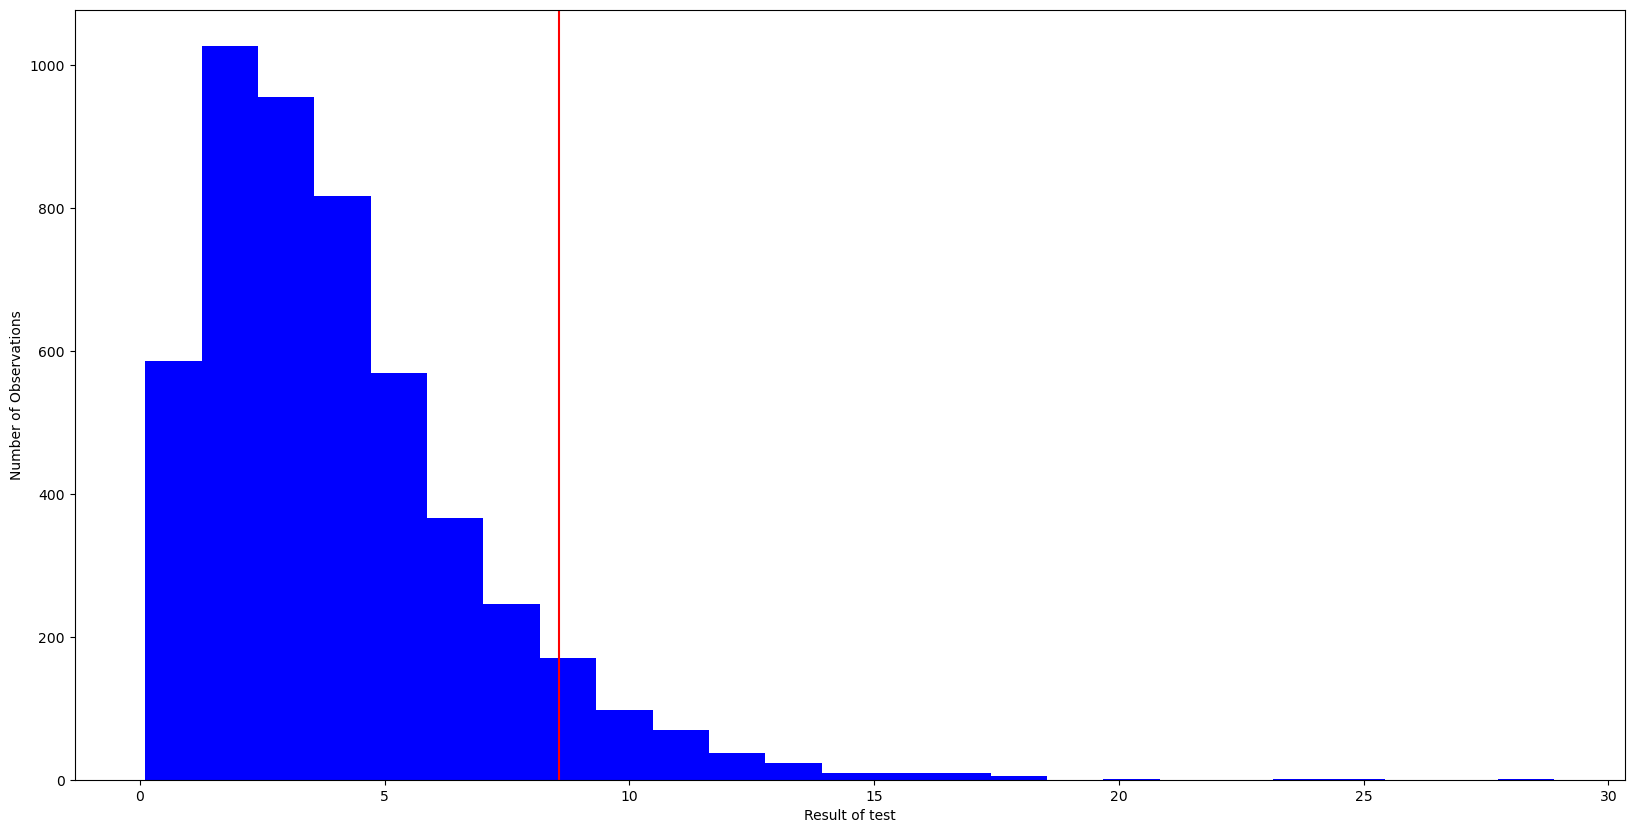

In [5]:
sampleData = permutation_test(df, X2, "dirGender", numIter = 5000)

Figure 1. Histogram showing the results of distribution following the randomization test on Chi squared (X2) values. Red line is the X2 value of the orginal data set.

### Question 6: Conclusion (5pts)
Written response: Based on the results, what can you conclude from this test? 

Based on the results and the p-value being above 0.05 it can be concluded that there is no systematic relationship between director gender and film genre, therefore we reject the alternative hypothesis and accept the null hypothesis. 

# TASK 2: Randomization test for mean differences (25pts)
In this task we will test the hypothesis that male and female directors differ in their annual income. Note that the hypothesis is undirected, meaning it could mean either that men earn more than women, or that women earn more than men.

### Question 1: Null hypothesis (5pts)
Formulate the Null-hypothesis. 

N0: There is no difference between director gender and annual income.

### Question 2: Difference of means (8pts)
Write a function that calculates and returns the difference in director salaries depending on the gender (male average income – female average income). Report the value. 

In [6]:
def probDiff(D):
    
    menIncome = D["dirIncome"].groupby(D["dirGender"]).get_group("male").mean()

    womenIncome = D["dirIncome"].groupby(D["dirGender"]).get_group("female").mean()
    
    difference = menIncome - womenIncome
    
    return difference

print(f"The difference in average income between males and females is {probDiff(df):.6f}")

The difference in average income between males and females is 0.639045


### Question 3:  Randomization test (7pts)
Use your randomization test function to perform a randomization test to determine whether the reported difference is statistical significant. Plot a histogram of the null-distribution and the real value. Report the p-value for the two-sided test. 

The result of the two sided test is 0.0014


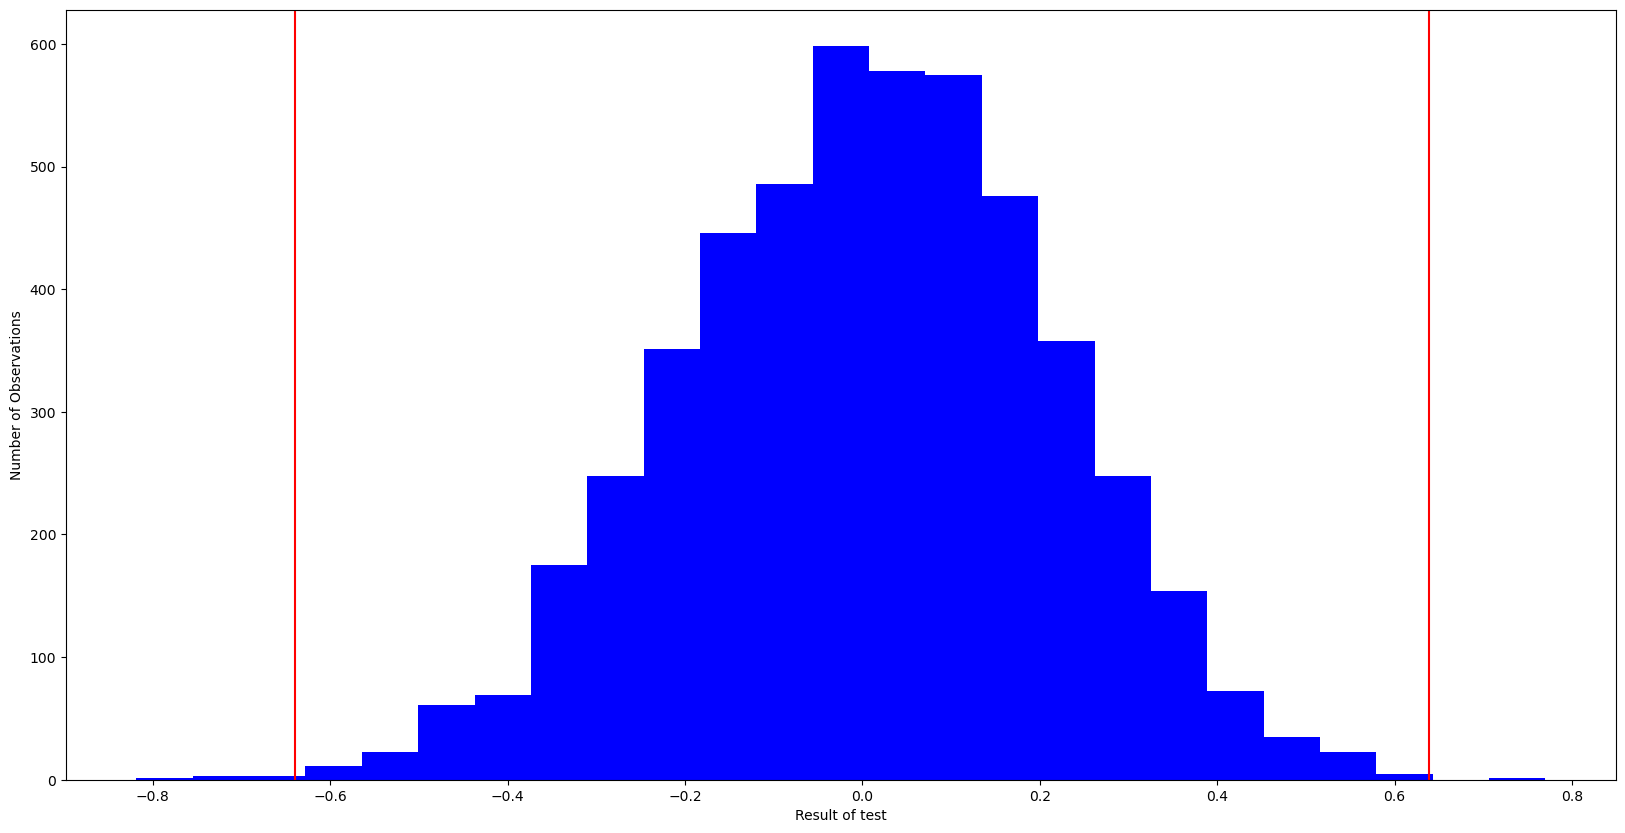

In [7]:
store = permutation_test(df, probDiff, shuffle = "dirGender", numIter = 5000, sides = 2)

Figure 2. Histogram showing the results of distribution following the randomization test on the difference of income between male and female directors (male - female). Red lines are the difference of the orginal data set. 

### Question 4: Conclusion (5pts)
What do you conclude about the relationship between gender and salary? What can you conclude about the claim that there is gender discrimination in the American film industry?  


It can be concluded that there is significant difference between director gender and income. The p value is below 0.05 leading to the rejection of the null hypothesis that there is no significant change. It is very likely that there is gender discrimination in the American film industry in terms of income. 

# Task 3: Monte-Carlo simulation test (35pt)
People providing an organ for donation sometimes seek help from a medical consultant. These consultants assist the patient in all aspects of the surgery. Patients might choose a consultant based in part on the historical complication rate of the consultant's clients. Consultant R tries to attract patients by noting the average complication rate for liver donor surgeries in the US is about 10%, but her clients have had only 3 complications in the 62 liver donor surgeries she has facilitated. She claims this is strong evidence that her work meaningfully contributes to reducing complications (and therefore she should be hired!).
### Question 1: Monte Carlo simulation (15pts)
Write a function (monteCarloSim) that simulates coin tossing. On each trial, the function should produce a specific number (N) of coin tosses and record the number of successes (heads). It should repeat this experiment numIter number of times. The inputs to the function should be a) probability of a success on each coin toss, b) the number of coin tosses per trial (N) and c) the number of trials. The function should return an np.array(range(numIter)) that holds the recorded number of heads for all trials (see lecture handout for tips).

In [8]:
def monteCarloSim(prob, N, t):

    numHead = np.array([])

    for trial in range(0, t):
        sim = np.random.choice([0,1], size = N, replace = True, p = prob) # p is probability per element
        numHead = np.append(numHead, np.sum(sim))
    
    return numHead

### Question 2: Monte Carlo Test (15pts)
Write a function (monteCarloTest) that uses monteCarloSim (Question 1) to simulate 2000 trials of a N coin tosses. 
The function should take as input arguments: 

* `H0prob`: The probability of heads under the Null hypothesis
* `N`: The number of coin throws per trial 
* `numHeads`: The number of observed coin tosses.  

After getting the simulation result from `monteCarloSim`, the function should plot a histogram of the recorded number of heads, and mark the real measured number (`numHeads`) with a vertical line. The function should print out the probability that the simulated number of heads is smaller than or equal to the measured number of heads.  

Use the function to evaluate the medical advisor example from the lecture: Determine the probability to get 3 complications in 62 cases if the probability of a complication in the population is known to be 10%. 

In [9]:
def monteCarloTest(H0prob, N, numHeads):
    data = monteCarloSim(H0prob, N, 2000)
    
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20,10))
    axes.hist(data, bins = 15, color = 'b')
    plt.axvline(x = numHeads, color = 'r')
    axes.set_ylabel("Number of Observations")
    axes.set_xlabel(f"Number of Complications")
    
    a = data <= numHeads
    p = sum(a) / len(data)
    print(f"The p-value is {p}")
    
    
    return data 


The p-value is 0.126


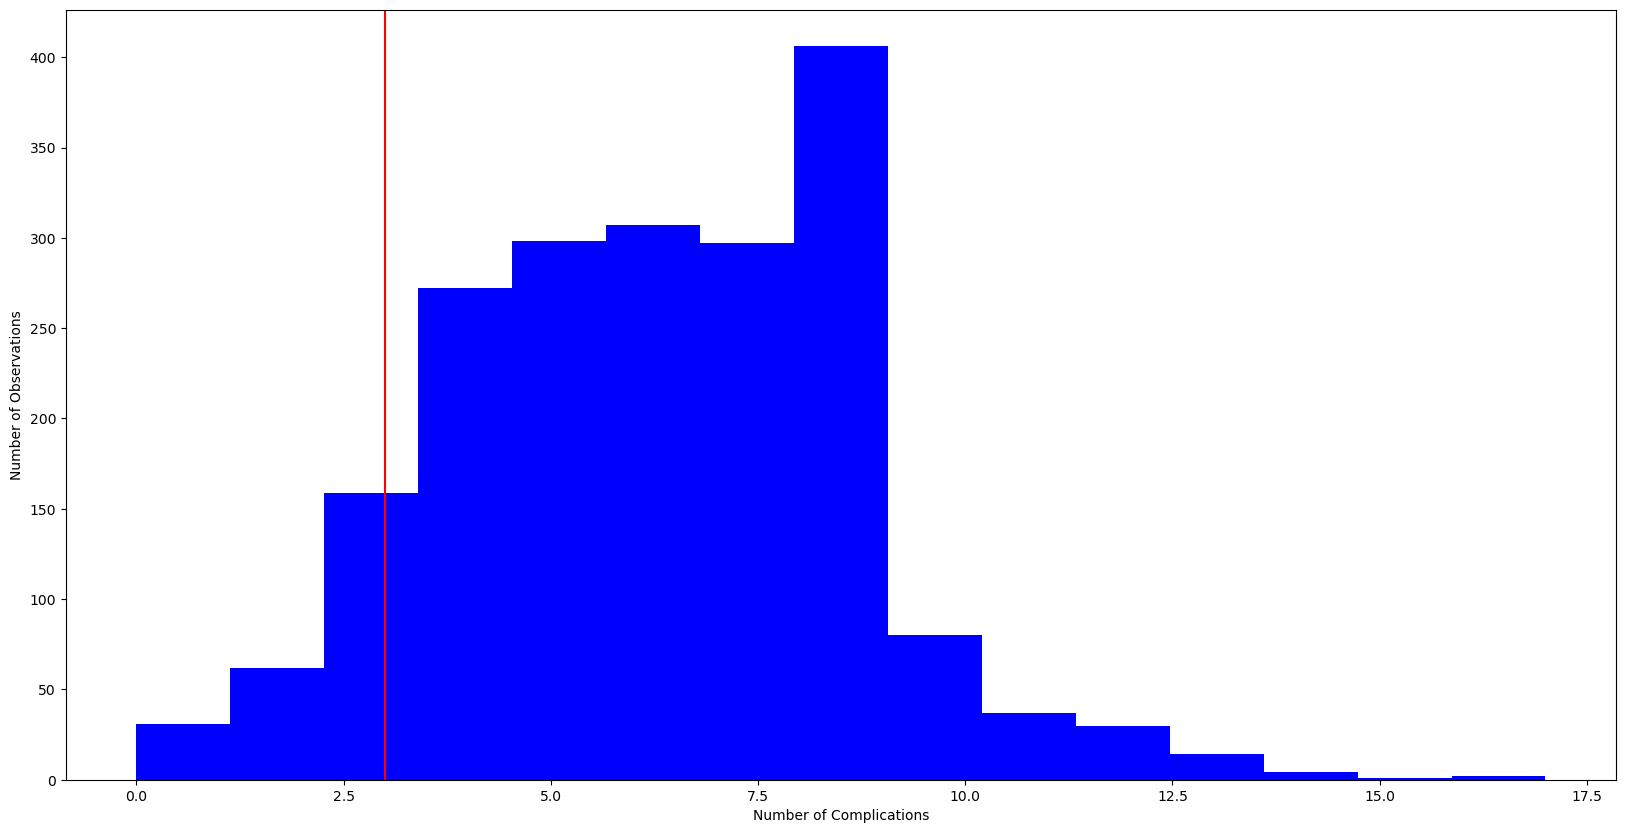

In [10]:
store = monteCarloTest([0.9,0.1], 62, 3)

Figure 3. Histogram showing the results of distribution following the monte carlo test, where values were summed and recored with 0 was a success and 1 was a failure (complication). The red line represents the number of complications that advisor R claims to have.

### Question 3: Conclusion (5pts)
Written answer: What do you conclude about the claim that the work of advisor R is lowering complication rates?

I can conclude that the work of advisor R is not actively lowering complication rates as the p-value shows no statistical significance. 